# Libraries

In [1]:
##########==========##########==========##########==========##########==========

## libraries
#import sys
#!{sys.executable} -m pip install python-docx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## general purpose visualization settings
set_font = {'L':42, 'M':28, 'S': 14}
set_color = {'Foreground':'#000000', 'Photo':'#202020', 'Visit':'#404040',
             'Unvisit':'#606060', 'Background':'#808080'}

## general purpose data
def compile_text(address = 'A_Input/paragraph_text'):
    from os import listdir
    from docx import Document
    x = listdir(address)
    y = dict()
    extract_text = lambda x: x.text
    for i in x:
        j = Document(address + '/' + i).paragraphs
        j = map(extract_text, j)
        y[i.replace('.docx', '')] = list(j)
        
    return y

city_list = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Cities')
route_list = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Routes')
panel_paragraph = compile_text()

# Basic Dashboard Architecture

Style: Define custom style elements for the visualization

In [2]:
## computations
def define_style():
    pass
## test
def test_style():
    pass

Layout: Make the layout underlying the visualization

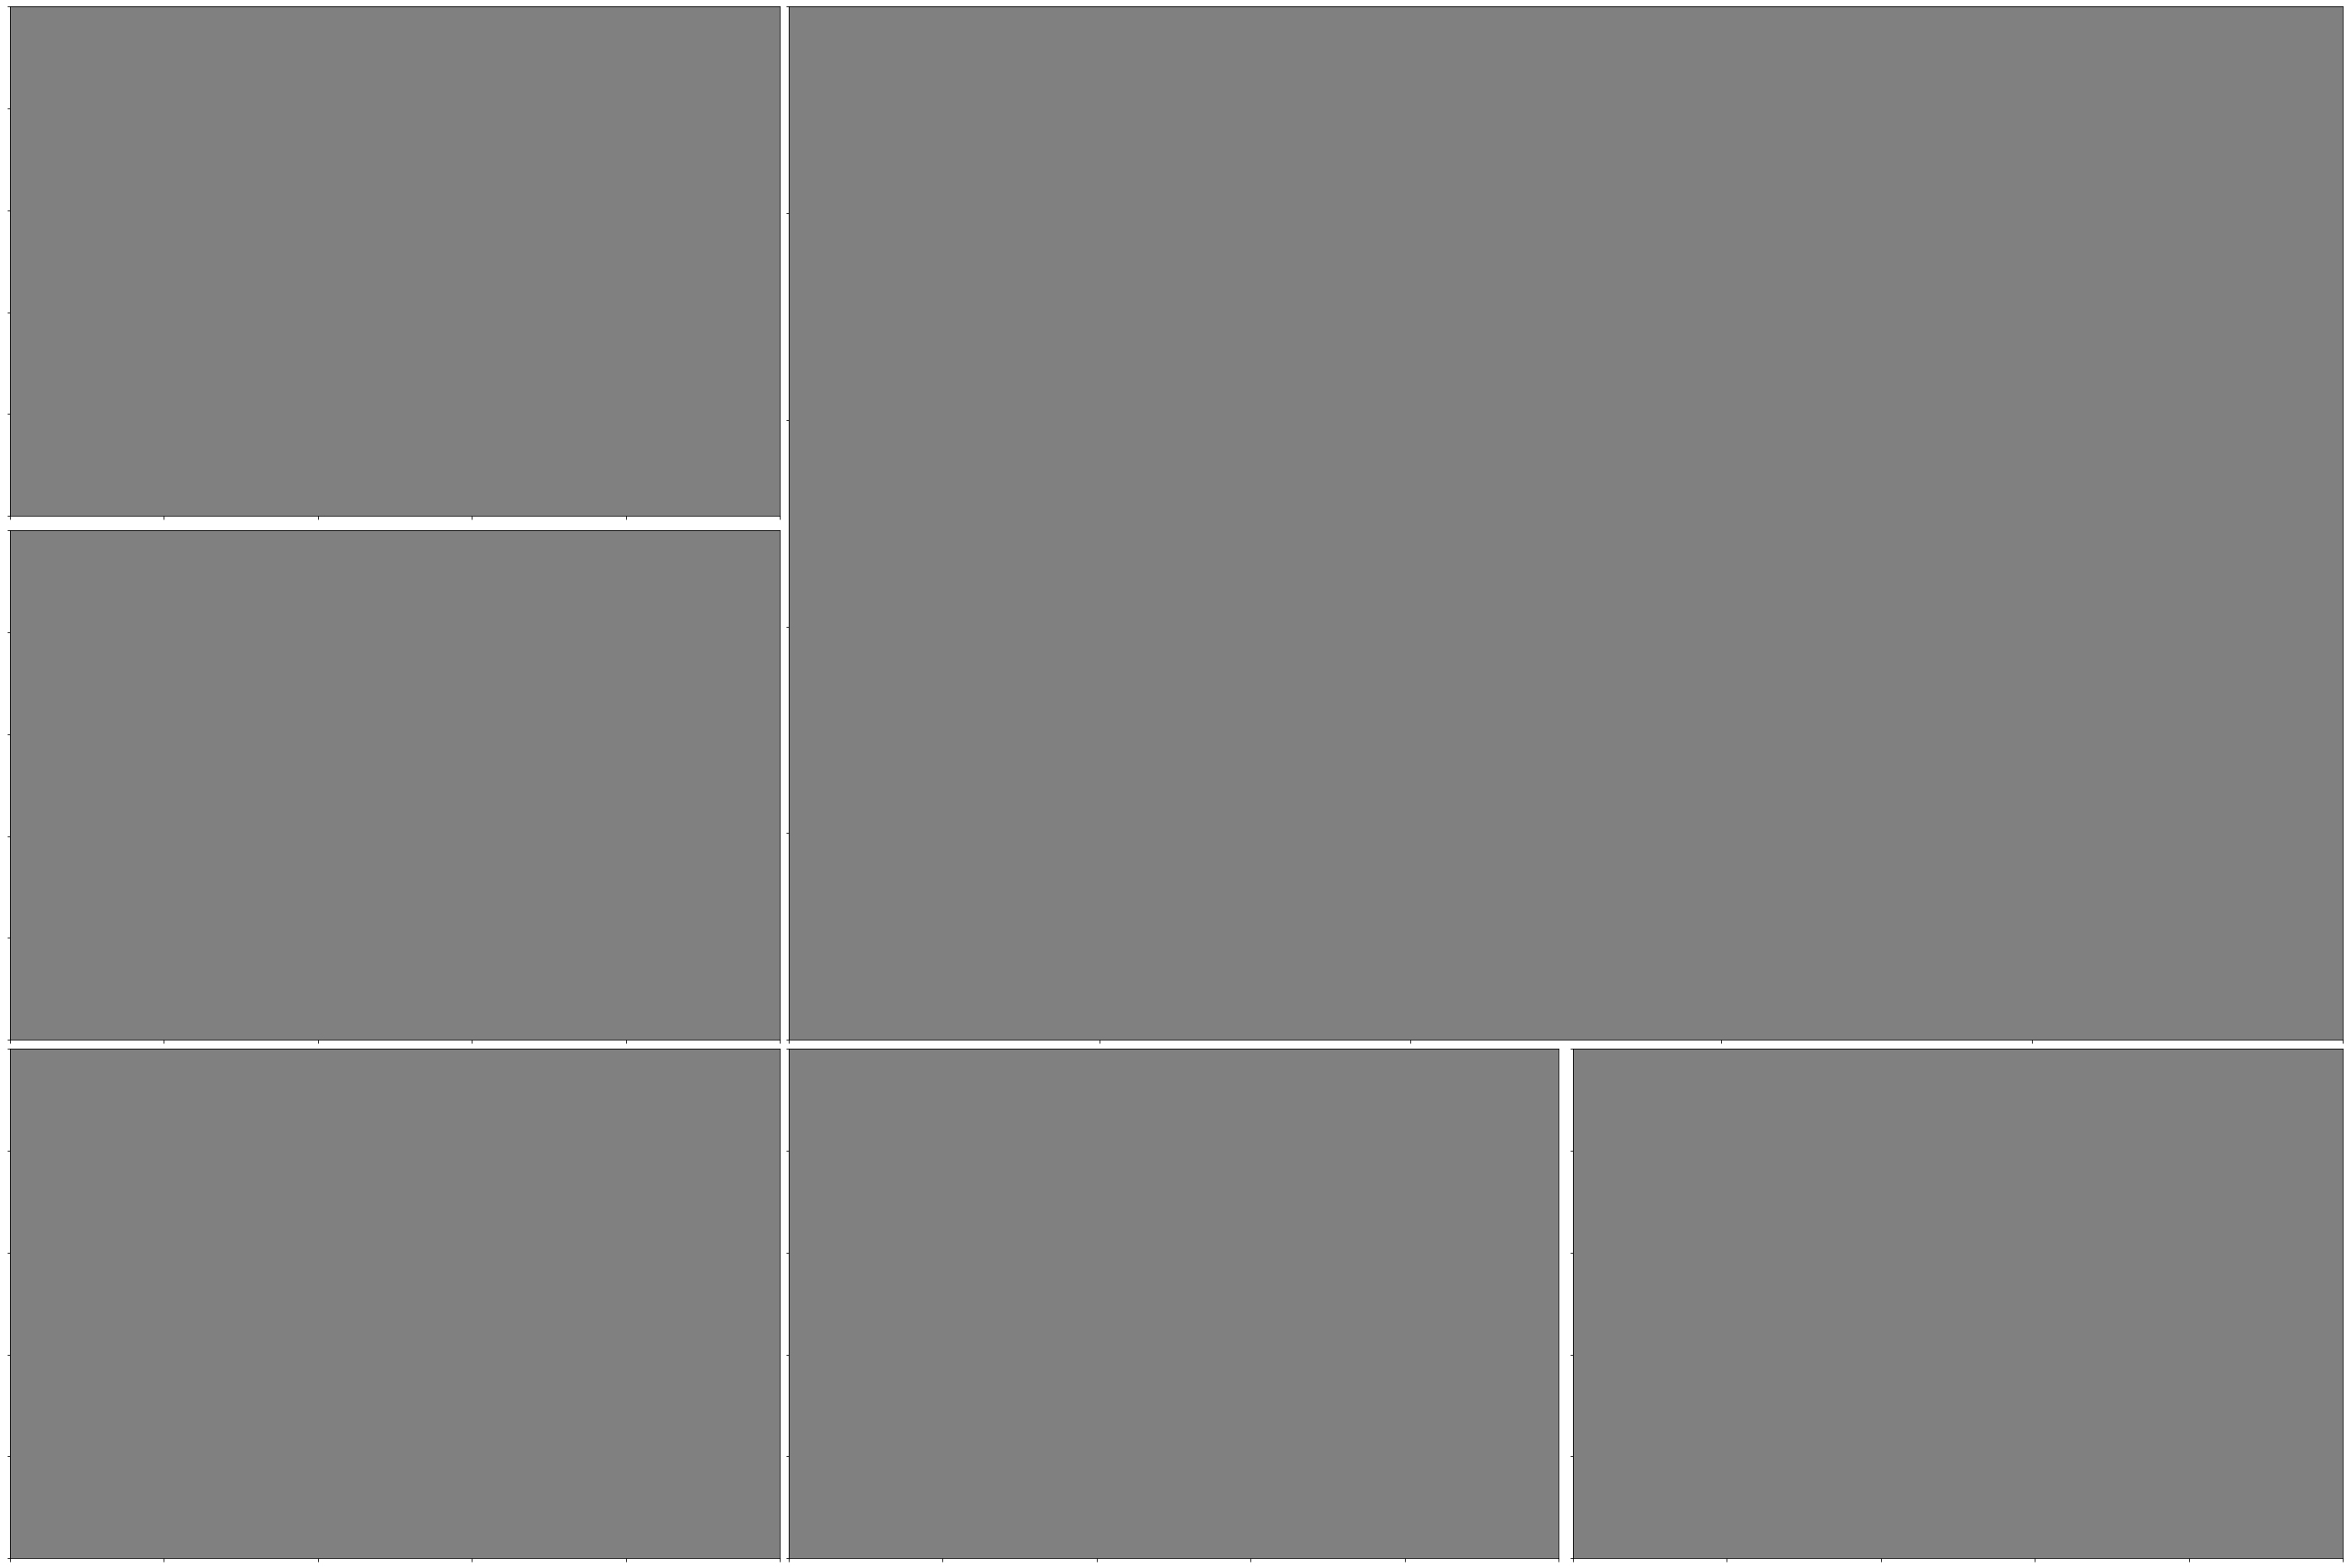

In [3]:
## computations
def process_layout():
    
    ## import needed objects
    from matplotlib.pyplot import figure
    from matplotlib.gridspec import GridSpec
    from matplotlib.colors import hsv_to_rgb
    
    ## generate segmented plotting space
    dashboard_figure = figure(
        figsize = (36, 24),
        constrained_layout = True
        )
    fig_grid  = GridSpec(3, 3,
                         figure = dashboard_figure,
                         wspace = 0.00,
                         hspace = 0.00
                        )
    
    ## define each plot panel
    axis_travels = dashboard_figure.add_subplot(fig_grid[0:2, 1:3])

    axis_explanation = dashboard_figure.add_subplot(fig_grid[0, 0])
    axis_progress    = dashboard_figure.add_subplot(fig_grid[1, 0])
    axis_routes      = dashboard_figure.add_subplot(fig_grid[2, 0])

    axis_opportunity = dashboard_figure.add_subplot(fig_grid[2, 1])
    axis_legend_plus = dashboard_figure.add_subplot(fig_grid[2, 2])
    
    ## package results
    dashboard = {'travels': axis_travels,
                   'explanation': axis_explanation,
                   'routes': axis_routes,
                   'progress': axis_progress,
                   'opportunity': axis_opportunity,
                   'legend_plus': axis_legend_plus}
    for iter in dashboard.keys():
        dashboard[iter].tick_params(
            labelbottom = False,
            labeltop = False,
            labelleft = False,
            labelright = False
            )
        dashboard[iter].set_facecolor( set_color['Background'] )
    
    ## return results
    return dashboard_figure, dashboard

dashboard_figure, dashboard = process_layout()

## display
def display_layout(the_figure):
    the_figure.savefig("C_Output/us_travels.png")
    the_figure.savefig("C_Output/us_travels.pdf")

## test
def test_layout():
    print("Have you visually confirmed that the diagram matches dashboard_plan.pptx?")

# Non-Map Dashboard Panels

Explanation: Make explanation / introduction text panel

In [4]:
## text formater helper function
def format_text(x, cl):
    
    ## prepare for text processing
    x = x.split(" ")
    even_lines = [x[0]]
    x = x[1:]
    current_line = 0
    
    ## segment text into lines <= 80 characters
    for i in x:
        if len(even_lines[current_line] + ' ' + i) > cl:
            current_line += 1
            even_lines.append(i)
        else:
            even_lines[current_line] = even_lines[current_line] + ' ' + i
    
    ## combine lines into a single string
    y = str()
    for i in even_lines:
        y = y + '\n' + i
    return y

def loop_format_text(x, char_len):
    y = ''
    for i in x:
        formatted_x = format_text(i, cl = char_len)
        y = y + formatted_x
    return y

## computations
def process_explanation(x = panel_paragraph['explanation']):
    
    ## format text into lines of <= 80 characters
    formatted_text = loop_format_text(x, char_len = 58)
    return formatted_text


## display
def display_explanation(explain):
    dashboard['explanation'].set_xlim(0, 12)
    dashboard['explanation'].set_ylim(0,  8)
    dashboard['explanation'].text(0.1, 0, s = explain,
                                  fontsize = set_font['M'],
                                  color = set_color['Foreground'],
                                  horizontalalignment = 'left',
                                  verticalalignment = 'bottom'
                                 )
    ## title
    dashboard['explanation'].text(0.1, 7.9, 
        s = 'MY TRAVELS IN THE UNITED STATES',
                                  fontsize = set_font['L'],
                                  color = set_color['Foreground'],
                                  horizontalalignment = 'left',
                                  verticalalignment = 'top'
                                 )

## test
def test_explanation():
    pass

## execute
explanation = process_explanation()
display_explanation(explanation)


Progress: Make horizontal bar charts depicting progress towards city and state travel goals

In [5]:
## computations
def process_progress(x = city_list):
    
    ## identify unvisited cities
    city_list['Unvisit'] = 1 - city_list['Visit']
    
    ## tabulate summary statistics (state_level)
    state_stats = city_list[['State', 'Photo', 'Visit', 'Unvisit']]
    state_stats = state_stats.groupby('State').max().drop(['CAN', 'PR', 'DC'])
    state_stats['Visit'] = state_stats['Visit'] - state_stats['Photo']
    state_stats['Unvisit'] = 1 - (state_stats['Visit'] + state_stats['Photo'])
    state_stats = state_stats.sum()

    ## tabulate summary statistics (city-level)
    city_list['Visit'] = city_list['Visit'] - city_list['Photo']
    city_stats = city_list[['Photo', 'Visit', 'Unvisit']].sum()
    
    ## package and return data
    y = pd.DataFrame({
        'City': city_stats,
        'State': state_stats
    })
    y = pd.melt(y, ignore_index = False).reset_index()
    y.columns = ['Status', 'Entity', 'Count']
    return y

## display
def display_progress(x, explain = panel_paragraph['progress']):
    
        ## set useful measurements
    use_measure = {'bar_start': 1.0, 'bar_height': 3 / 5}
    
    ## scale counts to match plotting coordinates
    func = lambda a: np.cumsum(a / sum(a))
    scaled_count = x[['Entity', 'Count']].groupby('Entity')
    scaled_count = scaled_count.transform(func)
    x['X'] = (scaled_count * (4.4 - use_measure['bar_start']))
    del scaled_count, func
    
    ## generate y coordinates
    x['Y'] = (x['Entity'] == 'State').astype(int)
    
    ## render horizontal barplots
    dashboard['progress'].set_xlim(0, 4.5)
    dashboard['progress'].set_ylim( 0 - (1 - use_measure['bar_height']), 2.8)
    for i in ['Unvisit', 'Visit', 'Photo']:
        dashboard['progress'].barh(
            y = x.loc[x['Status'] == i, 'Entity'],
            width = x.loc[x['Status'] == i, 'X'], 
            height = use_measure['bar_height'],
            left = use_measure['bar_start'],
            align = 'edge',
            color = set_color[i]
            )
    ## render bar count labels
    for i in range(x.shape[0]):
        if x['Count'].astype(int)[i] > 3:
            dashboard['progress'].text(
                x = x['X'][i] - 0.01 + use_measure['bar_start'],
                y = x['Y'][i] + 0.02,
                s = x['Count'].astype(int)[i],
                color = set_color['Foreground'],
                fontsize = set_font['S'],
                horizontalalignment = 'right',
                verticalalignment = 'bottom',
                bbox = dict(pad = 0.1, fc = '#FFFFFF88', ec = '#FFFFFF00',
                            boxstyle = 'Round', mutation_aspect = 1.1)
                )
    ## render legend
    dashboard['progress'].legend(
        labels = ['Unvisited', 'Visited', 'Photographed'],
        fontsize = set_font['S']
        )
    ## render title and explanation
    dashboard['progress'].text(0.05, 3 - 0.25, 
        s = 'TITLE GOES HERE',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'top'
        )
    dashboard['progress'].text(0.05, 3.0 - 0.25 - 0.1, 
        s = loop_format_text(panel_paragraph['progress'], 50),
        fontsize = set_font['M'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'top'
        )
    dashboard['progress'].text(
        x = use_measure['bar_start'],
        y = 0.0 + use_measure['bar_height'] / 2,
        s = "PLACEHOLD \nTEXT ",
        verticalalignment = 'center',
        horizontalalignment = 'right',
        fontsize = set_font['M']
    )

## test
def test_progress(x):
    pass

## execute
progress = process_progress()
display_progress(progress)

Legend Plus: Display table with legend and other information about planned routes

In [6]:
## plt.table(cellText = , rowLabels = , colLabels = , edges = 'open')
## AX.add_table()
## https://matplotlib.org/stable/gallery/misc/table_demo.html#sphx-glr-gallery-misc-table-demo-py
## cellText -> list of lists, each bottom-level list is a row of values


## computations
class LegendTable:
    
    def __init__(self, pd_df):
        x = pd_df['drive_mileage'].array
        x = np.ceil(x / 25) * 25
        pd_df.loc[:, 'drive_mileage'] = x.astype(int)
        del x
        self.table = [list(pd_df.iloc[i]) for i in range(pd_df.shape[0])]
        self.index = pd_df.index
        self.columns = pd_df.columns
        
    def __str__(self):
        print('Columns:')
        for i in self.columns:
            print(i, end = ' ')
        print('\n----')
        for i in self.table:
            print(i)
        return ''


def process_legend_plus(rl = route_list):
    rl = rl[['route', 'pre_travel', 'drive_mileage', 'trip_days',
             'best_temp_1', 'best_temp_2']]
    return LegendTable(rl)
    
## display
def display_legend_plus(rl):
    
    ## set parameters for plot
    dashboard['legend_plus'].set_xlim(0, 12)
    dashboard['legend_plus'].set_ylim(0, 8)
    
    ## render table
    y = dashboard['legend_plus'].table(
        cellText = rl.table,
        rowLabels = None,
        colLabels = rl.columns,
        edges = 'open',
        loc = 'lower right',
        colLoc = 'right'
        )
    y.auto_set_font_size(False)
    y.set_fontsize(set_font['S'])
    y.scale(0.8, 2.5)

    ## title
    dashboard['legend_plus'].text(0.1, 8.0 - 0.1, 
        s = 'TITLE GOES HERE',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'top'
        )
    
    ## color key
    dashboard['legend_plus'].scatter(
        [0.1 + 1.00 for i in range(15)],
        [0.43 * (i + 1) for i in range(15)],
        marker = 's',
        s = 60,
        c = set_color['Foreground']
        )
    
    
## test
def test_legend_plus():
    pass

## execute
legend_plus = process_legend_plus()
display_legend_plus(legend_plus)
display_layout(dashboard_figure)


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Map Dashboard Panels

Map: Make the background map underlying the map panels
+ Need to evaluate different options for AK, HI, PR insets

In [7]:
## computations
def process_map():
    pass
## display
def display_map():
    pass
## test
def test_map():
    pass

Routes: Map planned routes

In [8]:
## computations
def process_routes():
    pass
## display
def display_routes():
    pass
## test
def test_routes():
    pass

Opportunity: Map geographic areas where visit will contribute to goals
+ Kernel density heat map with plasma color scaling

In [9]:
## computations
def process_opportunity():
    pass
## display
def display_opportunity():
    pass
## test
def test_opportunity():
    pass

Travels: Map past travels

In [10]:
## computations
def process_travels():
    pass
## display
def display_travels():
    pass
## test
def test_travels():
    pass

# Finish Rendering Visualization

In [11]:
display_layout(dashboard_figure)
test_layout()

Have you visually confirmed that the diagram matches dashboard_plan.pptx?
